 # Question 2:

# Part 1.

Data loaded successfully.


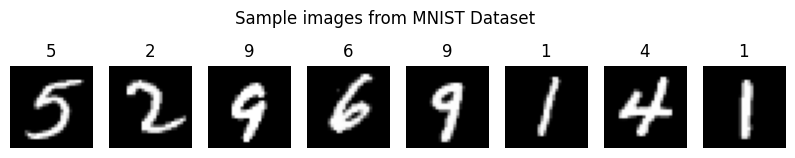

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

# Define transformation for MNIST dataset
transform = transforms.Compose([
    transforms.ToTensor()
])

# Load MNIST  dataset
mnist_train = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
mnist_test = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Create DataLoaders
train_loader = torch.utils.data.DataLoader(mnist_train, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(mnist_test, batch_size=64, shuffle=False)
print("Data loaded successfully.")

# Show 8 sample images from the training set
data_iter = iter(train_loader)
images, labels = next(data_iter)

plt.figure(figsize=(10, 2))
for i in range(8):
    plt.subplot(1, 8, i + 1)
    plt.imshow(images[i].squeeze(), cmap='gray')
    plt.title(str(labels[i].item()))
    plt.axis('off')

plt.suptitle("Sample images from MNIST Dataset")
plt.show()

# Part 2 & 3.

Epoch [25/25]: 100%|██████████| 92/92 [00:01<00:00, 64.91it/s, L_con=0.0306]


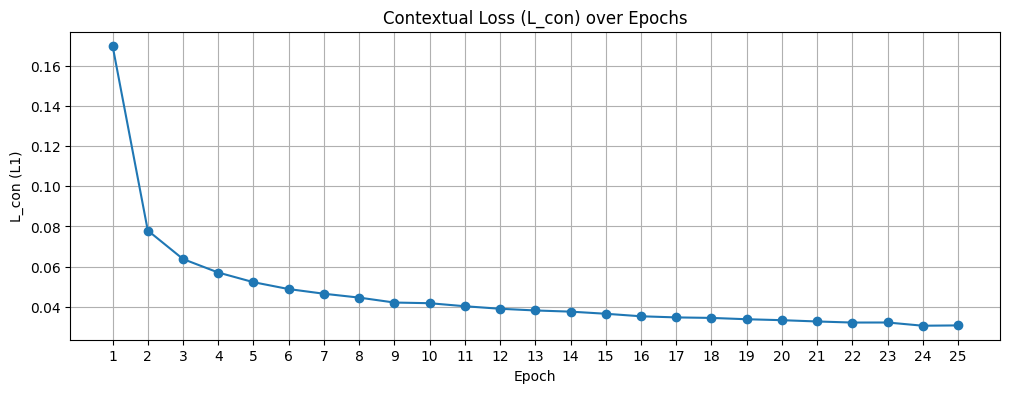

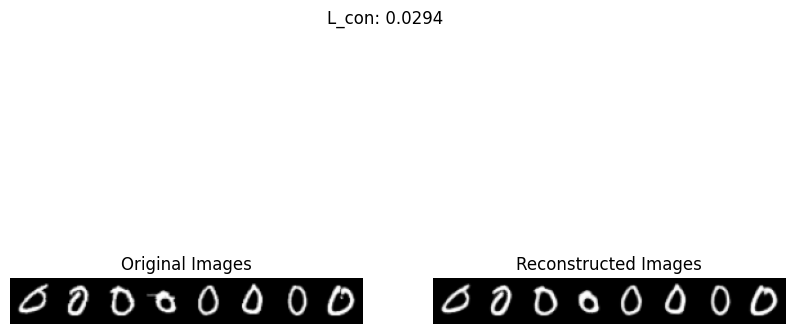

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from tqdm import tqdm

# Configuration parameters
class Config:
    dataset = "MNIST"
    img_size = 32
    input_channels = 1
    latent_dim = 100
    batch_size = 64
    num_workers = 2
    num_epochs = 25
    learning_rate = 2e-3
    beta1 = 0.5
    beta2 = 0.999
    w_adv = 1.0
    w_con = 50.0
    w_enc = 1.0
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

cfg = Config()

# Define Generator network (Encoder + Decoder)
class Generator(nn.Module):
    def __init__(self, in_channels=1, latent_dim=100):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels, 64, 4, 2, 1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, 4, 2, 1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, 4, 2, 1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, latent_dim, 4, 1, 0)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(latent_dim, 256, 4, 1, 0),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(256, 128, 4, 2, 1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(128, 64, 4, 2, 1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(64, in_channels, 4, 2, 1),
            nn.Tanh()
        )
    def forward(self, x):
        z = self.encoder(x)
        x_hat = self.decoder(z)
        return x_hat, z

# Auxiliary Encoder
class AuxiliaryEncoder(nn.Module):
    def __init__(self, in_channels=1, latent_dim=100):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels, 64, 4, 2, 1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, 4, 2, 1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, 4, 2, 1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, latent_dim, 4, 1, 0)
        )
    def forward(self, x_hat):
        return self.encoder(x_hat)

# Contextual Loss (L_con)
def contextual_loss(x, x_hat, loss_type='L1'):
    if loss_type == 'L1':
        return F.l1_loss(x_hat, x)
    elif loss_type == 'L2':
        return F.mse_loss(x_hat, x)
    else:
        raise ValueError("Invalid loss_type! Use 'L1' or 'L2'")

# Load only class 0 samples from MNIST for training
def get_dataloader():
    transform = transforms.Compose([
        transforms.Resize(cfg.img_size),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])
    full_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
    filtered_dataset = [sample for sample in full_dataset if sample[1] == 0]
    return DataLoader(filtered_dataset, batch_size=cfg.batch_size, shuffle=True,
                      num_workers=cfg.num_workers, drop_last=True)

if __name__ == '__main__':
    train_loader = get_dataloader()
    generator = Generator(cfg.input_channels, cfg.latent_dim).to(cfg.device)
    aux_encoder = AuxiliaryEncoder(cfg.input_channels, cfg.latent_dim).to(cfg.device)  # Not trained yet
    optimizer_G = torch.optim.Adam(generator.parameters(), lr=cfg.learning_rate, betas=(cfg.beta1, cfg.beta2))
    l_con_history = []

    # Training phase
    for epoch in range(cfg.num_epochs):
        loop = tqdm(train_loader, leave=True)
        total_l_con = 0.0
        for real_images, _ in loop:
            real_images = real_images.to(cfg.device)
            optimizer_G.zero_grad()
            reconstructed_images, _ = generator(real_images)
            loss_G_con = contextual_loss(real_images, reconstructed_images, loss_type='L1')

            loss_G_con.backward()
            optimizer_G.step()
            total_l_con += loss_G_con.item()
            loop.set_description(f"Epoch [{epoch+1}/{cfg.num_epochs}]")
            loop.set_postfix(L_con=loss_G_con.item())
        avg_l_con = total_l_con / len(train_loader)
        l_con_history.append(avg_l_con)


    plt.figure(figsize=(12, 4))
    plt.plot(range(1, cfg.num_epochs + 1), l_con_history, marker='o')
    plt.title('Contextual Loss (L_con) over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('L_con (L1)')
    plt.grid(True)
    plt.xticks(range(1, cfg.num_epochs + 1))
    plt.show()

    # show reconstructions
    data_iter = iter(train_loader)
    real_images, _ = next(data_iter)
    real_images = real_images.to(cfg.device)
    generator.eval()
    with torch.no_grad():
        reconstructed_images, _ = generator(real_images)
    generator.train()

    plt.figure(figsize=(10, 6))
    plt.subplot(1, 2, 1)
    plt.title("Original Images")
    img_grid_real = torchvision.utils.make_grid(real_images[:8].cpu(), nrow=8, normalize=True)
    plt.imshow(img_grid_real.permute(1, 2, 0).squeeze(), cmap='gray')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.title("Reconstructed Images")
    img_grid_recon = torchvision.utils.make_grid(reconstructed_images[:8].cpu(), nrow=8, normalize=True)
    plt.imshow(img_grid_recon.permute(1, 2, 0).squeeze(), cmap='gray')
    plt.axis('off')

    plt.suptitle(f"L_con: {contextual_loss(real_images, reconstructed_images, loss_type='L1').item():.4f}")
    plt.show()

# Part4.

In [4]:
# Configuration parameters
class Config:
    dataset_name = "MNIST"
    img_size = 32
    input_channels = 1
    latent_dim = 100
    batch_size = 64
    num_workers = 2
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
cfg = Config()

# Shared Encoder
class SharedEncoder(nn.Module):
    def __init__(self, in_channels=1, latent_dim=100):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels, 64, 4, 2, 1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, 4, 2, 1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, 4, 2, 1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, latent_dim, 4, 1, 0)
        )
    def forward(self, x):
        return self.encoder(x)

# Decoder
class Decoder(nn.Module):
    def __init__(self, out_channels=1, latent_dim=100):
        super().__init__()
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(latent_dim, 256, 4, 1, 0),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(256, 128, 4, 2, 1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(128, 64, 4, 2, 1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(64, out_channels, 4, 2, 1),
            nn.Tanh()
        )
    def forward(self, z):
        return self.decoder(z)

# Define Generator network
class Generator(nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
    def forward(self, x):
        z = self.encoder(x)
        x_hat = self.decoder(z)
        return x_hat, z

# Auxiliary Encoder
class AuxiliaryEncoder(nn.Module):
    def __init__(self, encoder):
        super().__init__()
        self.encoder = encoder
    def forward(self, x_hat):
        return self.encoder(x_hat)

# Define Discriminator network
class Discriminator(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Flatten(),
            nn.Linear(latent_dim, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )
    def forward(self, z):
        return self.net(z.squeeze(-1).squeeze(-1))

if __name__ == '__main__':
    # Load MNIST and resize to 32x32
    transform = transforms.Compose([
        transforms.Resize(cfg.img_size),
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5])
    ])

    mnist = torchvision.datasets.MNIST(root='./data', train=True, transform=transform, download=True)
    train_loader = DataLoader(mnist, batch_size=cfg.batch_size, shuffle=True, num_workers=cfg.num_workers)

    # Instantiate models
    shared_encoder = SharedEncoder(cfg.input_channels, cfg.latent_dim).to(cfg.device)
    decoder = Decoder(cfg.input_channels, cfg.latent_dim).to(cfg.device)
    generator = Generator(shared_encoder, decoder).to(cfg.device)
    aux_encoder = AuxiliaryEncoder(shared_encoder).to(cfg.device)
    discriminator = Discriminator(cfg.latent_dim).to(cfg.device)

    for images, _ in train_loader:
        images = images.to(cfg.device)
        x_hat, z = generator(images)
        z_hat = aux_encoder(x_hat)
        d_out = discriminator(z)

        print(f"Input image shape:      {images.shape}")
        print(f"Reconstructed x̂ shape: {x_hat.shape}")
        print(f"z shape:                {z.shape}")
        print(f"ẑ shape:               {z_hat.shape}")
        print(f"D(z) shape:             {d_out.shape}")
        break

Input image shape:      torch.Size([64, 1, 32, 32])
Reconstructed x̂ shape: torch.Size([64, 1, 32, 32])
z shape:                torch.Size([64, 100, 1, 1])
ẑ shape:               torch.Size([64, 100, 1, 1])
D(z) shape:             torch.Size([64, 1])
